In [52]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# How Old is Mr. Krabs? – Optimize Your Farming with Crab Age Prediction

## Executive Summary

This project aims to build a __Crab Age Prediction Model__ where it can help identify the age of Mud Crabs from the dataset we got from Kaggle. A business case would be for a commercial crab farmer knowing the suitable period of the crab helps them decide if and when to harvest the crabs. Beyond a certain age, there is negligible growth in crab's physical characteristics and hence, it is crucial to time the harvesting to reduce cost and increase profit. Ideal weight is __700g - 1kg for Males__ and __400g - 500g for females__ and harvest time is between__4-6 months__ in some farms __3-8 months__. We also need to take note that this is the most important crab in the Philippines due to huge demand both locally and abroad. Most of the crab seeds are found in the Visayas region and we do Polyculture (grown with Milkfish and Tiger Prawns) to maximize the pond.

Here we have performed EDA to understand the nature of the data, performed data pre-processing, built an __11-in-1 Auto-ML pipeline__ to help determine the best model and hyperparameters through analysis of the summary table, perform feature engineering via deriving features, run through 3 of the best models and present the results and top-performing features. We have also performed further analysis on feature derivation and dropping of linear columns to show how it affects the overall accuracy. We've also understood that Weight, Height, Diameter, and Length are not enough to determine good accuracy of a crab's age or any living thing and we need additional features to help identify it.

Post the presentation Norman shot a question of getting the Shucked weight of the crab should they be dead already and this is where I got the intuition that we cannot collect it and have adjusted my data set and have shown a minimal reduction in the accuracy but the trade-off is good. A lower number of features faster run time and a data set is on the realistic side.

Based on the performance of the results we have managed to __improve the test accuracy by 25%+__ via the __feature engineering__ we did. Though improving the accuracy this much can help a lot since if the variance is too high it is hard for a farmer to decide if the crab is mature enough or if there's still room for growth. The mean absolute error of 1.8 (original data) and 1.0 (feature-engineered data) may provide bearing given that the farmers may have less likely to go beyond the later months of farming. Though this is an assumption on the farming side since I lack domain expertise it makes complete sense for someone who wants to make a profit to farm the crabs at the optimal age. 

Lastly, one practical use of this would be if farmers use the same pond, cage, or netted mangrove and out crabs in different periods he can easily predict the age using this model.

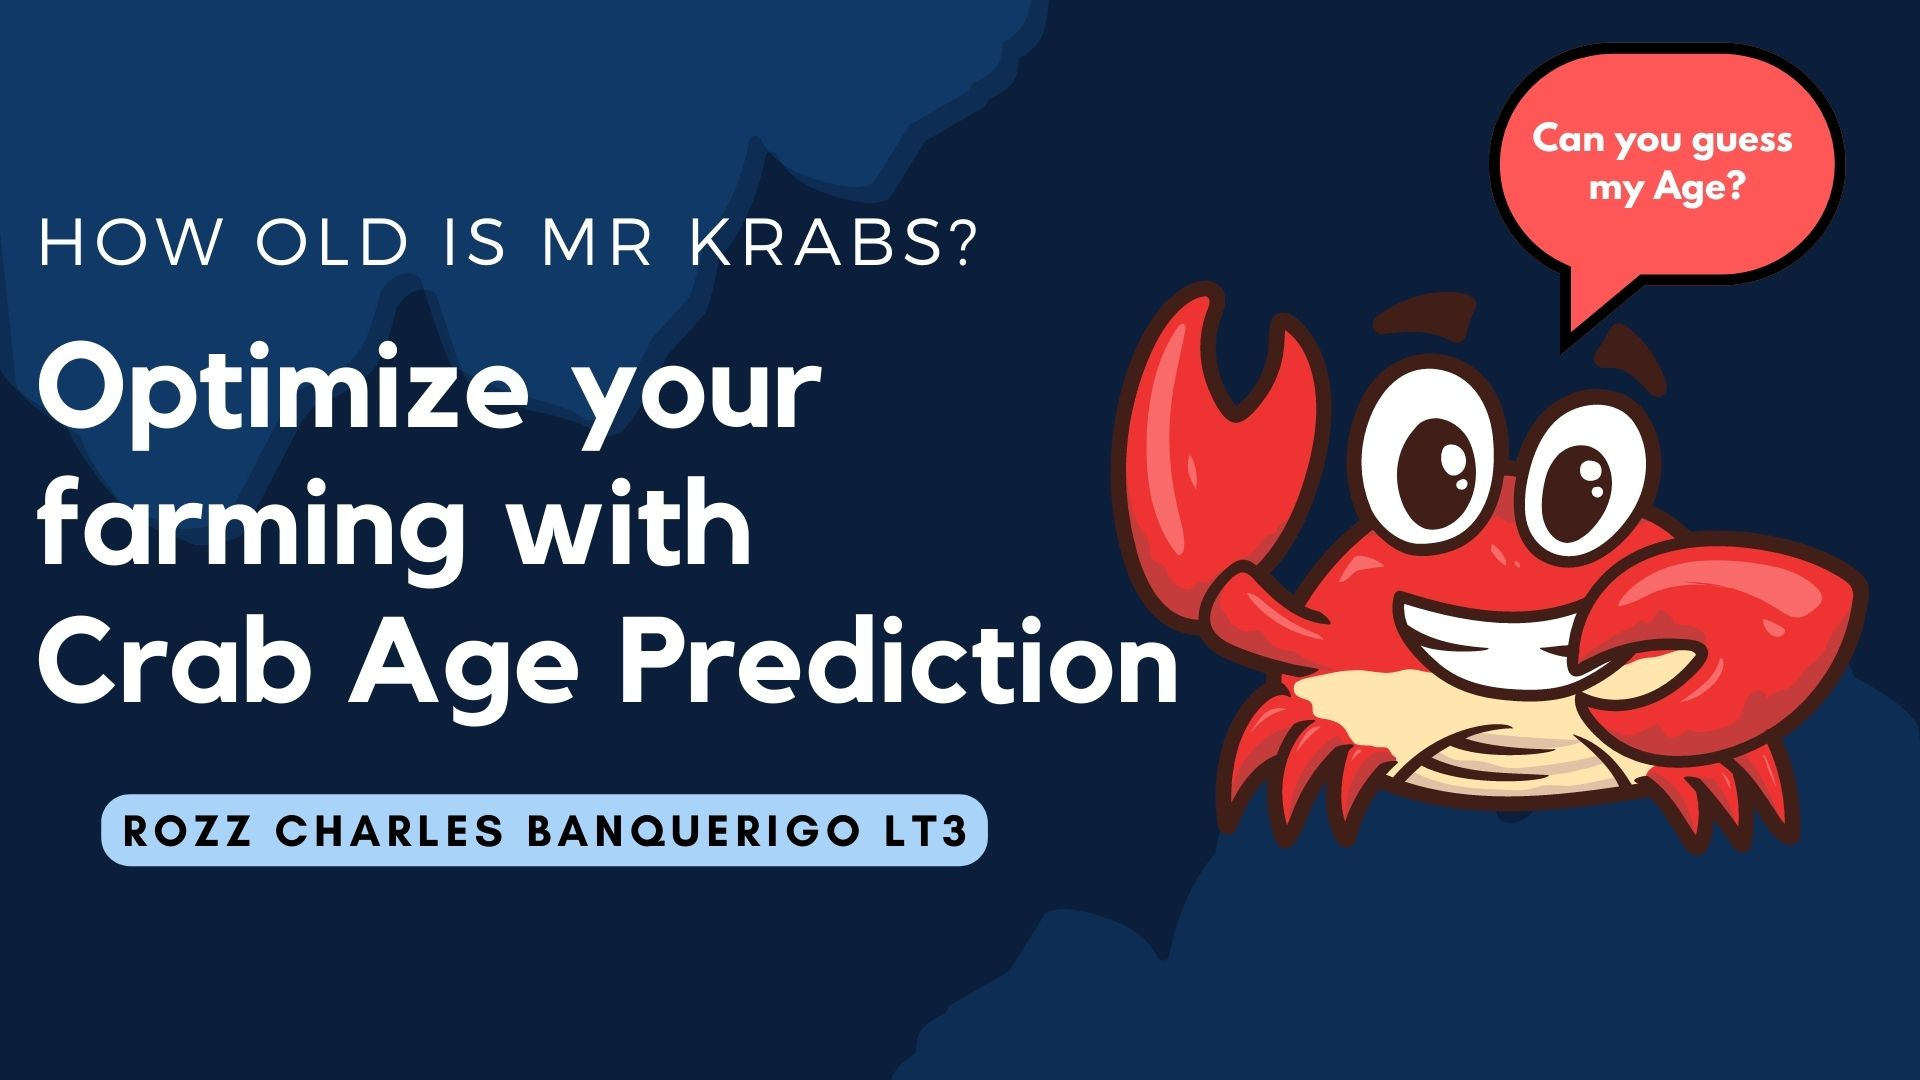

## Methodology

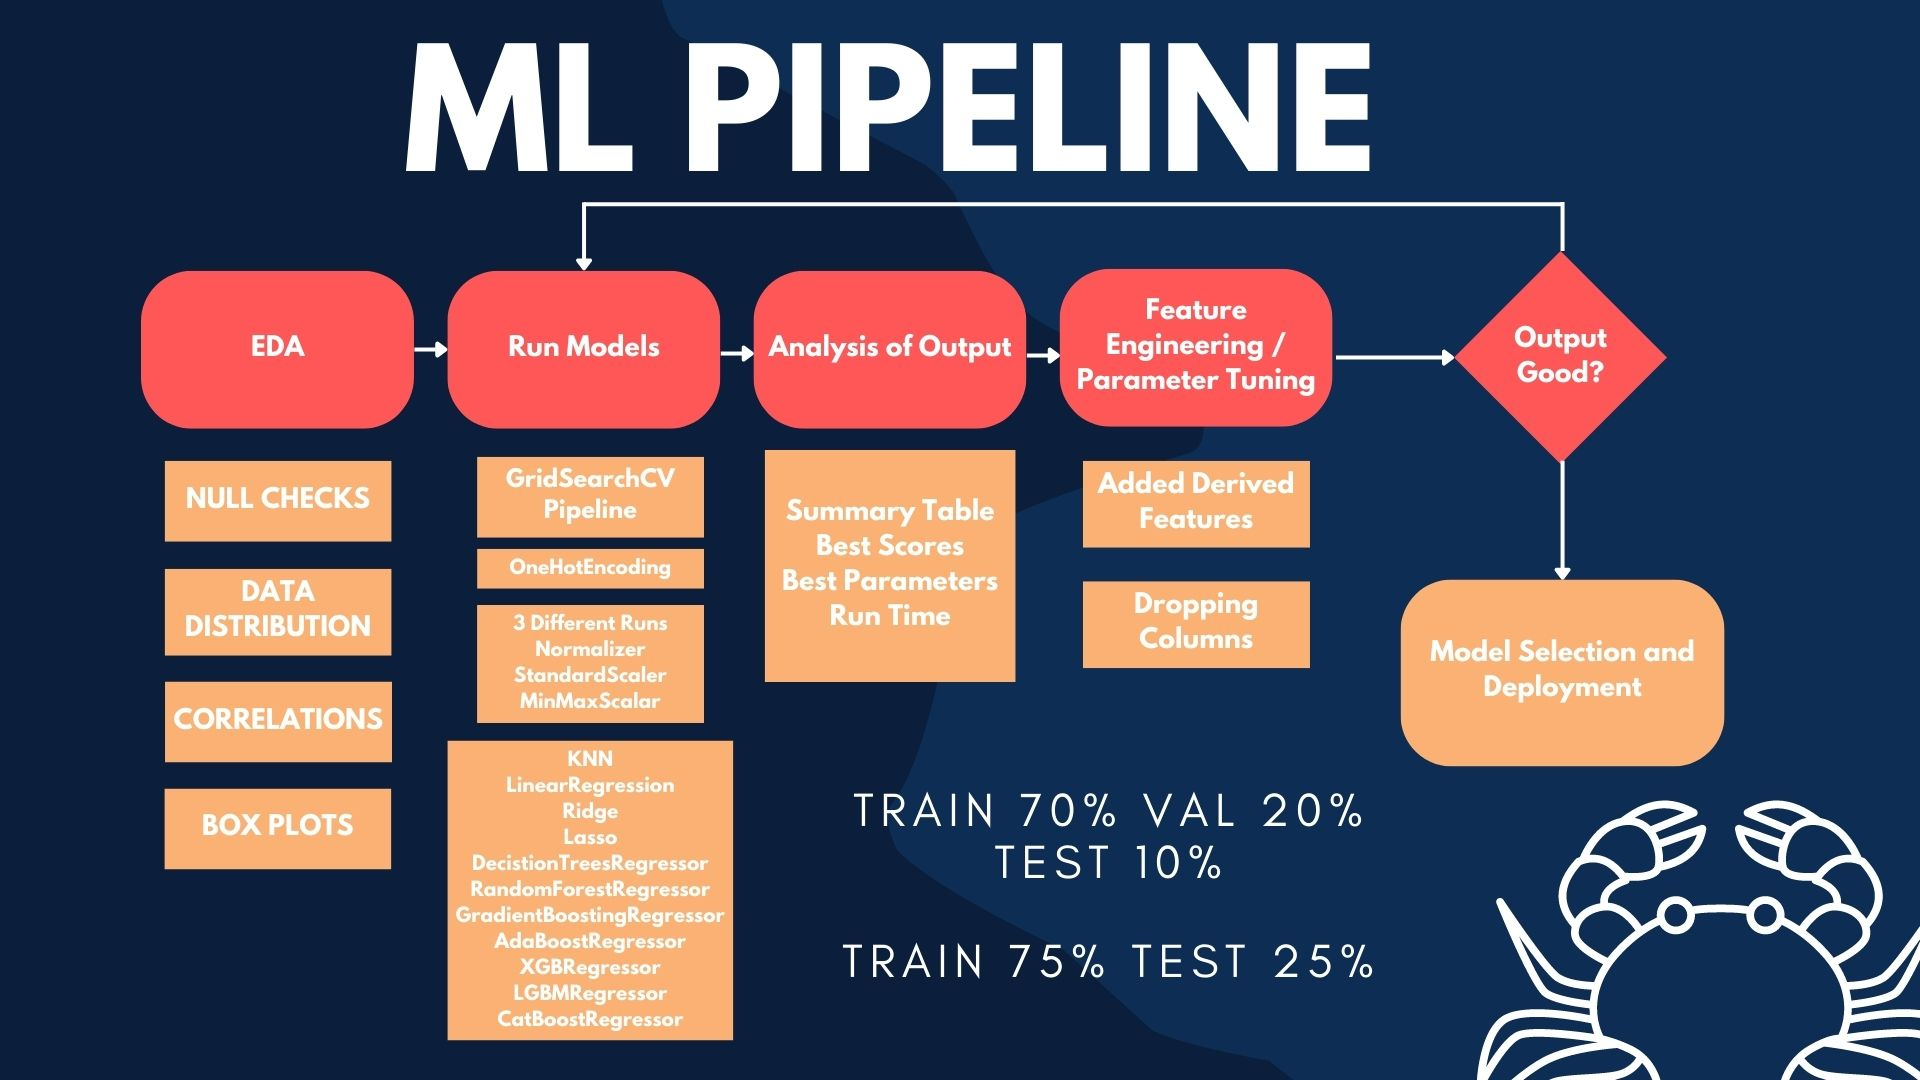

### Data Source and Description

__Kaggle URL: https://www.kaggle.com/datasets/sidhus/crab-age-prediction__ <br>

Feature Descriptu
__Sex__ : Gender of crab (M, F, I) <br>
__Length__ : Lenght of crab in Feet <br>
__Diameter__ : Diameter of crab in Feet <br>
__Height__ : Height of crab in Feet <br>
__Weight__ : Weight of crab in Ounces (sum of Shucked, Viscera and Shell) <br>
__Shucked Weight__ : Weight of crab without shell in Ounces <br>
__Viscera Weight__ : is weight that wraps around your abdominal organs deep inside body in Ounces <br>
__Shell Weight__ : Weight of shell <br>
__Age__ : Age of crab in months <br>


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as ltb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
pd.set_option('display.max_colwidth', None)

In [54]:
def function_that_warns():
    #warnings.warn("deprecated", DeprecationWarning)
    pass
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    function_that_warns()  # this will not show a warning

## EDA

Load crab data set and display first 5 rows

In [55]:
df_crab = pd.read_csv('crab-age.csv')
df_crab.head(5)

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


Null checks and we can see data is clean from missing values no need to do any imputation.

In [56]:
df_crab.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

We look into the min-max values of the data set and ideally given this gap we do not want to use `MinMaxScaler` though in my script I also executed it for the sake of testing normalized values. 

In [57]:
df_crab.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,1.311306,1.020893,0.349374,23.567275,10.207342,5.136546,6.795844,9.954791
std,0.300431,0.248233,0.104976,13.891201,6.275275,3.104133,3.943392,3.220967
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,1.362500,1.062500,0.362500,22.792998,9.539607,4.861939,6.662133,10.000000
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


Plotted the distribution of Crab age in Months and we can that is positively skewed. Majority of the values lies between 5 to 15 months

95% of the data lies between 6.0 and 16.0 


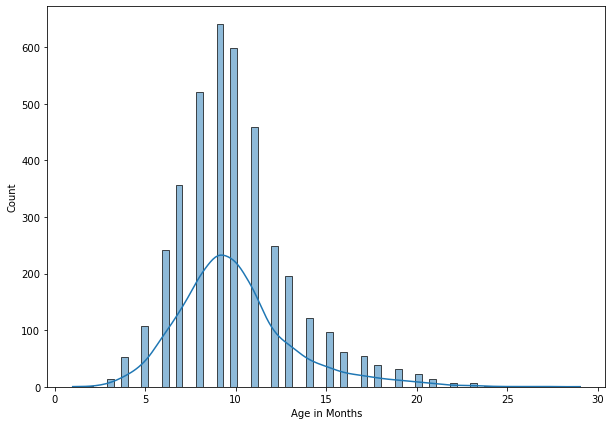

In [58]:
plt.rcParams["figure.figsize"] = (10, 7)
q = df_crab.Age.quantile([.05, .95])
print(f'95% of the data lies between {q[.05]} and {q[.95]} ')
ax = sns.histplot(df_crab, x='Age', kde=True)
ax.set_xlabel('Age in Months');

We can also see similar distribution for the crabs Sex

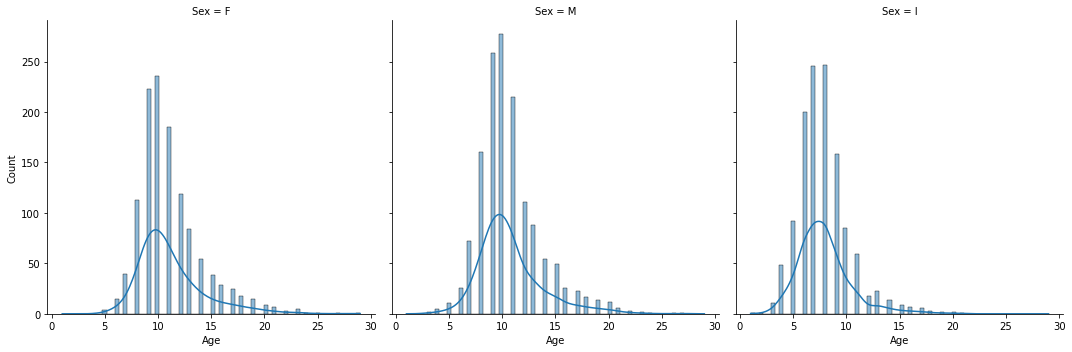

In [59]:
plt.rcParams["figure.figsize"] = (4, 2)
ax = sns.displot(df_crab, x="Age", col="Sex", kind='hist', kde=True)
plt.show()

We've also used box plot to identify the outliers within the data set and we can there's a lot of outliers for each of the features given that there's few data points for Ages below 5 and when it reaches beyond 20 since this. where the smaller and larges values comes from though I did not consider dropping them  since it would still help in the regression of values to identify higher and lower ages.

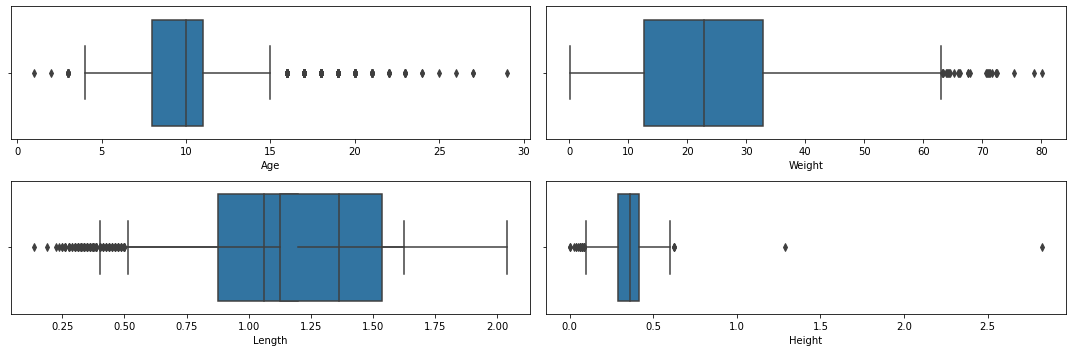

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,5))
sns.boxplot(x=df_crab['Age'], ax=ax[0][0])
sns.boxplot(x=df_crab['Weight'], ax=ax[0][1])
sns.boxplot(x=df_crab['Diameter'], ax=ax[1][0])
sns.boxplot(x=df_crab['Length'], ax=ax[1][0])
sns.boxplot(x=df_crab['Height'], ax=ax[1][1])
fig.tight_layout()

In the correlation heatmap below we can see multi colinearity on the features except height and its completely negatively correlated to our target where we would initially expect regression predictions would be low.

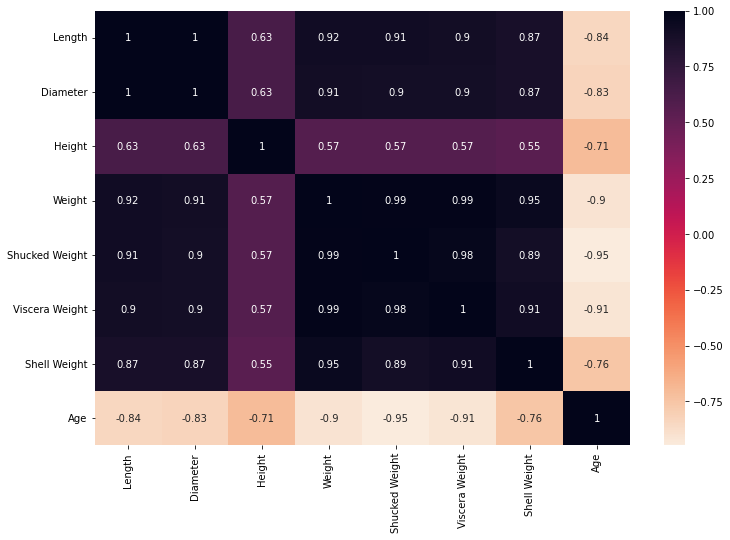

In [61]:
plt.rcParams["figure.figsize"] = (12, 8)
ax = sns.heatmap(df_crab.corr().corr(), cmap="rocket_r", annot=True)
plt.show()

In the Pairplot we can see the linear dependency across the features confirming the multicolinearity we've analyzed the correlation heatmap. 

The relationship with age also becomes non linear and spreads out as the age of the crab goes higher.

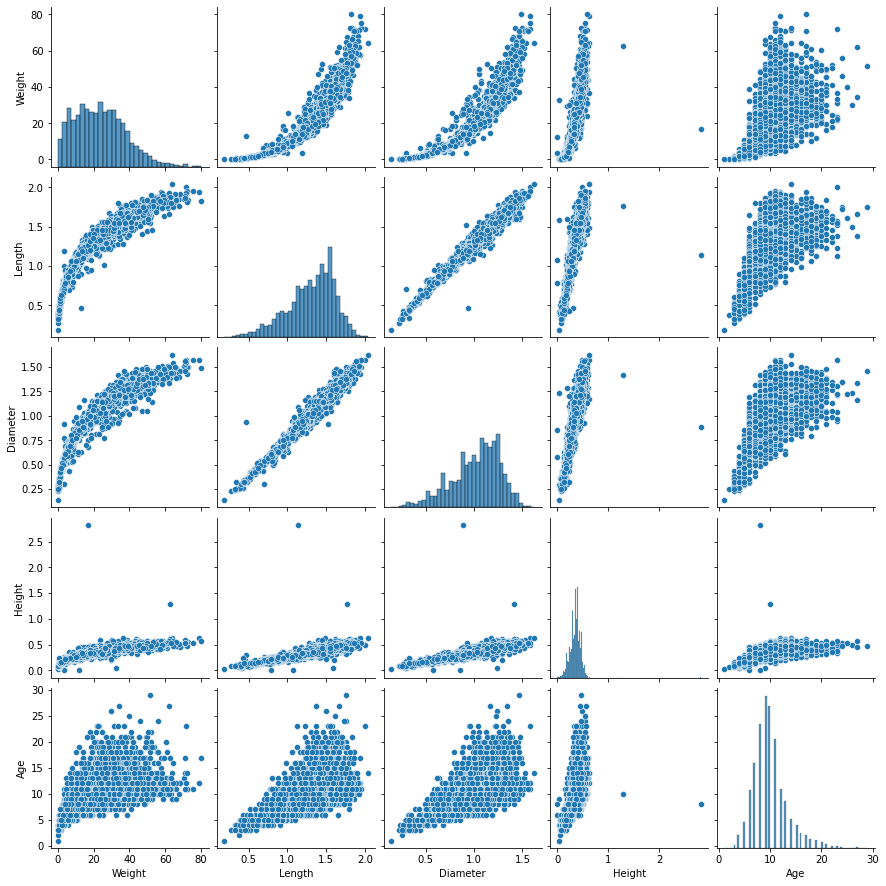

In [62]:
sns.pairplot(df_crab[['Weight', 'Length', 'Diameter', 'Height', 'Age']])
plt.show()

## Model Execution and Pre-processing

I've built the `train_model` an 11-in-1 AutoML function from scratch to process train, validation, and test data sets using `Pipeline` and `GridSearchCV`. This returns a data frame for easier interpretation of the results. We have predefined hyperparameters for each model and have also included the scaler to be executed with `kNN` and `Linear Models` but did not include it for the tree models as there's no impact for it. This model took some time to build as each model would be executed individually to test all features and have tested this with other data sets outside of crab and works like the AutoML we've shared in class.


__Please note this script does not run on jojie using our student's account and needs this to be executed on a more powerful machine.__

__It also took me couple of hours to fix the LightGBM installation on mac for newer chips since it cannot find the libomp automatically and need to install Homebrew and manually install libomp and create a symbolic link to point to the  folder location on homebrew.__

https://stackoverflow.com/questions/72285089/i-am-not-able-to-run-lightgbm-on-mac-because-of-an-oserror-libomp-dylib-no-su

In [68]:
def train_model(X, y, X_t, y_t):
    """
    Function access 4 parameters
    X - Train validation Feature data set
    y - Train validation Target data set
    X_t - Test Feature data set
    y_t - Test Target data set
    
    This function processes the inputs with 11 different models
    and summarizes the details into a data frame as a return
    value for easier interpretation. This also has pre-set hyper
    parameters and you can choose which data normalizer
    """
    k = list(np.arange(1, 51))
    cv = 5
    scoring = 'r2'
    step = 1
    alpha = [
        1e-20, 1e-10, 1e-5, 1e-4, 1e-3, .01, 0.1, 0.2, 0.4, 0.75, 1, 1.5, 3, 5,
        10, 15, 20, 100, 1000, 5000
    ]

    depth = list(np.arange(1, 17))
    n_estimators = [100, 300, 500]
    learning_rate = [0.1, 0.01, 0.001]
    learning_rate2 = [1, 0.1, 0.01, 0.001]
    num_leaves = [32, 48, 64]
    max_bin = [255, 555, 700]
    iterations = [1000000]
    random_state = [0]
    eta = [0.1, 0.2, 0.3]
    lst_summary = []
    scalers = [StandardScaler(), MinMaxScaler(), Normalizer()]

    grids = []

    for scaler in scalers:
        steps = [('scaler', scaler), ('clf', KNeighborsRegressor())]
        pipe = Pipeline(steps)
        param_grid = {
            'clf__n_neighbors': k,
            'clf__weights': ['uniform', 'distance']
        }
        gs = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,  # -1 to run jobs in parallel for faster runtime
            return_train_score=True
        )  # True to return both the train and test scores
        grids.append([gs, 'kNN', scaler])

        steps = [('scaler', scaler), ('clf', LinearRegression())]
        pipe = Pipeline(steps)
        param_grid = {}
        gs = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,  # -1 to run jobs in parallel for faster runtime
            return_train_score=True
        )  # True to return both the train and test scores
        grids.append([gs, 'Linear Regression', scaler])

        steps = [('scaler', scaler), ('clf', Lasso())]
        pipe = Pipeline(steps)
        param_grid = {'clf__alpha': alpha, 'clf__max_iter': iterations}
        gs = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,  # -1 to run jobs in parallel for faster runtime
            return_train_score=True
        )  # True to return both the train and test scores
        grids.append([gs, 'Lasso', scaler])

        steps = [('scaler', scaler), ('clf', Ridge())]
        pipe = Pipeline(steps)
        param_grid = {'clf__alpha': alpha, 'clf__max_iter': iterations}
        gs = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,  # -1 to run jobs in parallel for faster runtime
            return_train_score=True
        )  # True to return both the train and test scores
        grids.append([gs, 'Ridge', scaler])

    steps = [('scaler', None), ('clf', DecisionTreeRegressor())]
    pipe = Pipeline(steps)
    param_grid = {'clf__random_state': random_state, 'clf__max_depth': depth}
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,  # -1 to run jobs in parallel for faster runtime
        return_train_score=True
    )  # True to return both the train and test scores
    grids.append([gs, 'DT', None])

    steps = [('scaler', scaler), ('clf', RandomForestRegressor())]
    pipe = Pipeline(steps)
    param_grid = {
        'clf__random_state': random_state,
        'clf__max_depth': depth,
        'clf__n_estimators': n_estimators
    }
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,  # -1 to run jobs in parallel for faster runtime
        return_train_score=True
    )  # True to return both the train and test scores
    grids.append([gs, 'RF', None])

    steps = [('scaler', None), ('clf', GradientBoostingRegressor())]
    pipe = Pipeline(steps)
    param_grid = {
        'clf__random_state': random_state,
        'clf__max_depth': depth,
        'clf__n_estimators': n_estimators,
        'clf__learning_rate': learning_rate
    }
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,  # -1 to run jobs in parallel for faster runtime
        return_train_score=True
    )  # True to return both the train and test scores
    grids.append([gs, 'GBM', None])

    steps = [('scaler', None), ('clf', AdaBoostRegressor())]
    pipe = Pipeline(steps)
    param_grid = {
        'clf__n_estimators': n_estimators,
        'clf__learning_rate': learning_rate2
    }
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,  # -1 to run jobs in parallel for faster runtime
        return_train_score=True
    )  # True to return both the train and test scores
    grids.append([gs, 'AdaBoost', None])

    steps = [('scaler', None), ('clf', xgb.XGBRegressor(verbosity=0))]
    pipe = Pipeline(steps)
    param_grid = {'clf__eta': eta, 'clf__max_depth': depth}
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,  # -1 to run jobs in parallel for faster runtime
        return_train_score=True
    )  # True to return both the train and test scores
    grids.append([gs, 'XGB', None])

    steps = [('scaler', None), ('clf', ltb.LGBMRegressor(verbose=-1))]
    pipe = Pipeline(steps)
    param_grid = {
        'clf__max_depth': depth,
        'clf__learning_rate': learning_rate,
        'clf__max_bin': max_bin,
        'clf__n_estimators': n_estimators,
        'clf__verbose': [-1]
    }
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,  # -1 to run jobs in parallel for faster runtime
        return_train_score=True
    )  # True to return both the train and test scores
    grids.append([gs, 'LGB', None])

    steps = [('scaler', None), ('clf', CatBoostRegressor(silent=True))]
    pipe = Pipeline(steps)
    param_grid = {
        'clf__depth': list(np.arange(1, 7)),
        'clf__learning_rate': learning_rate
    }
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,  # -1 to run jobs in parallel for faster runtime
        return_train_score=True
    )  # True to return both the train and test scores
    grids.append([gs, 'Catboost', None])

    for i, m, s in grids:
        t_start_stime = time.time()
        i.fit(X, y)
        start_time = time.time()
        pred_perf = i.score(X_t, y_t)
        end_time = time.time() - start_time
        t_end_time = time.time() - t_start_stime
        if m != 'Catboost':
            best_est = i.best_estimator_.steps[step]
        else:
            best_est = 'NA'  #get_best_iteration does not work
        best_est = i.best_params_
        try:
            top_pred = X.columns[(np.argmax(
                i.best_estimator_.named_steps.clf.coef_))]
            pred_ = i.best_estimator_.named_steps.clf.coef_
        except:
            try:
                top_pred = X.columns[(np.argmax(
                    i.best_estimator_.named_steps.clf.feature_importances_))]
                pred_ = i.best_estimator_.named_steps.clf.feature_importances_
            except:
                pred_ = top_pred = 'N/A'

        lst_summary.append([
            m, s, best_est,
            i.__dict__['cv_results_']['mean_train_score'][i.best_index_],
            i.__dict__['cv_results_']['mean_test_score'][i.best_index_],
            pred_perf, top_pred,
            i.__dict__['cv_results_']['mean_fit_time'][i.best_index_],
            i.__dict__['cv_results_']['mean_score_time'][i.best_index_],
            end_time, t_end_time, pred_
        ])
    df_summary = pd.DataFrame(lst_summary,
                              columns=[
                                  'Model', 'Scaler', 'Method / Estimators',
                                  'Train Score', 'Validation Score',
                                  'Test Score', 'Top Predictor',
                                  'Fit Run Time', 'Val Run Time',
                                  'Test Run Time', 'Total Run Time', 'Features'
                              ])

    return df_summary

Part of the data pre-processing is `OneHotEncoding` the categorical features in our data set we only have `Sex` to be encoded and we used the `get_dummies` feature to transorm it.

We also needed to drop the target `Age` along with the encoded column as its not needed anymore.

In [69]:
dummies = pd.get_dummies(df_crab.Sex, prefix='sex', drop_first=False)
df_crab_dum = pd.concat([df_crab, dummies], axis=1)
df_crab_dum.drop(['Sex', 'Age'], inplace=True, axis=1)
df_crab_dum.head(5)

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,sex_F,sex_I,sex_M
0,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,1,0,0
1,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,0,0,1
2,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,0,1,0
3,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,1,0,0
4,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,0,1,0


Here we split the dataset into to parts 90% for train and validation, and 10% for test.

In [70]:
X_trainval, X_test, y_trainval, y_test = train_test_split(df_crab_dum,
                                                          df_crab['Age'],
                                                          test_size=0.10,
                                                          random_state=619)
print('features trainval dimension =', X_trainval.shape)
print('target trainval dimension =', y_trainval.shape)

features trainval dimension = (3503, 10)
target trainval dimension = (3503,)


### Baseline run using the original Features

Execution of the base dataset with only the OneHotEncoded features. The normalization of the values will be within the `Pipeline` of the `train_model`

Note: The Ridge regression is not ceonverging even at 1m iterations and have to leave it as is since it also has very low accuracy at all tests and I've focused more with working out the trees models.

In [72]:
df_base = train_model(X_trainval, y_trainval, X_test, y_test)

/Users/bossrozz/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.979e+02, tolerance: 2.976e+00
  model = cd_fast.enet_coordinate_descent(
/Users/bossrozz/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.927e+02, tolerance: 2.943e+00
  model = cd_fast.enet_coordinate_descent(
/Users/bossrozz/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

In [73]:
df_sorted = df_base.sort_values(by='Test Score', ascending=False)
df_sorted.drop('Features', axis=1, inplace=True)
display(df_sorted)

,Model,Scaler,Method / Estimators,Train Score,Validation Score,Test Score,Top Predictor,Fit Run Time,Val Run Time,Test Run Time,Total Run Time
8,kNN,Normalizer(),"{'clf__n_neighbors': 47, 'clf__weights': 'distance'}",1.000000,0.561860,0.593538,N/A,0.005248,0.019014,0.007882,4.874122
13,RF,None,"{'clf__max_depth': 7, 'clf__n_estimators': 100, 'clf__random_state': 0}",0.735134,0.574390,0.591767,Weight,0.814065,0.010352,0.006230,86.355651
18,Catboost,None,"{'clf__depth': 6, 'clf__learning_rate': 0.01}",0.636311,0.548644,0.589259,Shell Weight,2.665084,0.003303,0.007976,16.839405
16,XGB,None,"{'clf__eta': 0.1, 'clf__max_depth': 3}",0.653462,0.548565,0.586273,Shell Weight,0.163561,0.001996,0.003661,16.176341
14,GBM,None,"{'clf__learning_rate': 0.01, 'clf__max_depth': 4, 'clf__n_estimators': 500, 'clf__random_state': 0}",0.675365,0.541064,0.586055,Shell Weight,2.201889,0.007440,0.004361,250.370566
17,LGB,None,"{'clf__learning_rate': 0.01, 'clf__max_bin': 255, 'clf__max_depth': 6, 'clf__n_estimators': 500, 'clf__verbose': -1}",0.700352,0.555301,0.581842,Shucked Weight,0.239857,0.024868,0.004303,64.664545
7,Ridge,MinMaxScaler(),"{'clf__alpha': 0.1, 'clf__max_iter': 1000000}",0.532228,0.520139,0.580479,Weight,0.002035,0.000892,0.000709,0.162246
3,Ridge,StandardScaler(),"{'clf__alpha': 1, 'clf__max_iter': 1000000}",0.532686,0.520057,0.580282,Weight,0.001724,0.000637,0.000656,0.125028
2,Lasso,StandardScaler(),"{'clf__alpha': 0.001, 'clf__max_iter': 1000000}",0.532708,0.520123,0.580098,Weight,0.019260,0.001144,0.000988,62.393873
6,Lasso,MinMaxScaler(),"{'clf__alpha': 0.001, 'clf__max_iter': 1000000}",0.531885,0.520191,0.580092,Weight,0.013742,0.001591,0.001113,52.943783


Top 3 performing models for the base run we can use this to compare the results later.

In [74]:
display(df_sorted.head(3))

,Model,Scaler,Method / Estimators,Train Score,Validation Score,Test Score,Top Predictor,Fit Run Time,Val Run Time,Test Run Time,Total Run Time
8,kNN,Normalizer(),"{'clf__n_neighbors': 47, 'clf__weights': 'distance'}",1.000000,0.561860,0.593538,N/A,0.005248,0.019014,0.007882,4.874122
13,RF,None,"{'clf__max_depth': 7, 'clf__n_estimators': 100, 'clf__random_state': 0}",0.735134,0.574390,0.591767,Weight,0.814065,0.010352,0.006230,86.355651
18,Catboost,None,"{'clf__depth': 6, 'clf__learning_rate': 0.01}",0.636311,0.548644,0.589259,Shell Weight,2.665084,0.003303,0.007976,16.839405


Based on the initial accuracies above we can now use this as a baseline for our future fine-tuning of the parameters. `kNN` interestingly performed the best and even scored perfect in the training set with `RF` with near test scores and higher validation scores though both `RF` and `Catboost` executed longer than the `kNN`.

1. The accuracy is as expected given there's a lack of features that correlates with the Target.
2. It's a common understanding that `Height, Weight, Length`, and `Diameter` are not good estimators given that they will normalize at some point like humans where we peak in growth and are only identified by facial features or other descriptors like years working or graduation date.

Note:
This is already executed with hyperparameters defined but I executed this with not much tuning and the results on the accuracy are way lower than this. From this point forward after adjusting the parameters I've worked on doing feature engineering

## Feature Engineering

Below is the final derived feature which is `Month` and binning the age by 6 since this would be easier to estimate and still yield good accuracy. <br><br>
The motivation to include it is that if there's a pond, cage, or netted mangrove the farmer would have a rough idea of which crabs have been added to it and can easily say that a crab might be "6 months" due to his experience and with the aid of the model they can narrow down the exact age of the crab.<br>
I've also tried doing BMI for crabs or summing up features and then squaring it did not help in the accuracy at all there's a negligible difference with the results. <br>

Since there's a lack of feature identifiers for crabs and we need to kill them before knowing an estimated age it is not feasible for this use case as we need the crabs alive as part of the delivery requirements. 
Unlike humans as Prof. Chris mentioned we are identified through facial features to determine age.

https://www.adfg.alaska.gov/index.cfm?adfg=wildlifenews.view_article&articles_id=845



In [76]:
df_crab_m = df_crab.copy()
df_crab_m['Month'] = pd.cut(df_crab.Age,
                            list(range(0, 36, 6)),
                            labels=list(range(1, 6)))
df_crab_m['Month'] = df_crab_m['Month'].astype(int)

An updated correlation heatmap shows the linear dependency between `Month` and `Age` hence will be expecting good improvement in the accuracy'

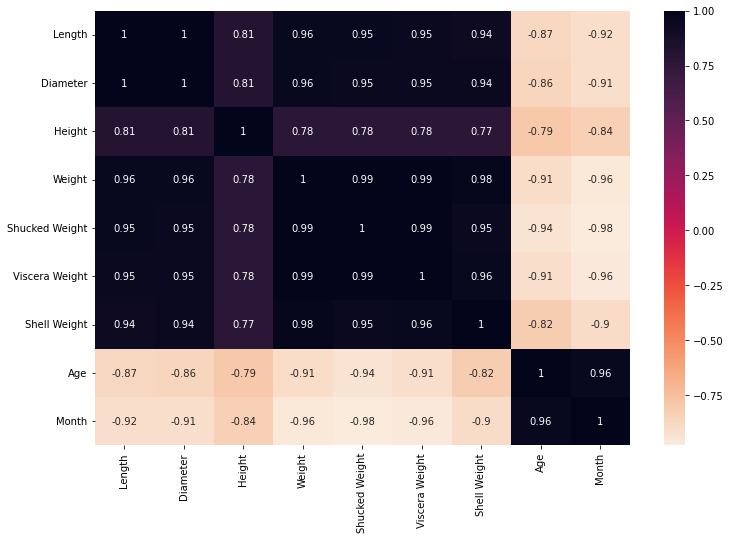

In [77]:
plt.rcParams["figure.figsize"] = (12, 8)
ax = sns.heatmap(df_crab_m.corr().corr(), cmap="rocket_r", annot=True)
plt.show()

## Re-execution of the model with the added `Month` Feature

Preparation of the dataset same as previous data processing.

In [78]:
#Added
dummies = pd.get_dummies(df_crab_m.Sex, prefix='sex', drop_first=False)
df_crab_dum = pd.concat([df_crab_m, dummies], axis=1)
df_crab_dum.drop(['Sex', 'Age', 'Month'], inplace=True, axis=1)
df_crab_dum['Month'] = pd.cut(df_crab.Age,
                              list(range(0, 36, 6)),
                              labels=list(range(1, 6)))
df_crab_dum['Month'] = df_crab_dum['Month'].astype(int)
df_crab_dum.head(5)

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,sex_F,sex_I,sex_M,Month
0,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,1,0,0,2
1,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,0,0,1,1
2,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,0,1,0,1
3,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,1,0,0,2
4,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,0,1,0,1


Same data split of 90% train, validation and 10% test

In [79]:
X_trainval, X_test, y_trainval, y_test = train_test_split(df_crab_dum,
                                                          df_crab['Age'],
                                                          test_size=0.10,
                                                          random_state=619)
print('features trainval dimension =', X_trainval.shape)
print('target trainval dimension =', y_trainval.shape)

features trainval dimension = (3503, 11)
target trainval dimension = (3503,)


Execution of the updated dataset with added `Month` feature. The normalization of the values will be within the Pipeline of the train_model.



In [80]:
df_improved = train_model(X_trainval, y_trainval, X_test, y_test)

/Users/bossrozz/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e+02, tolerance: 2.931e+00
  model = cd_fast.enet_coordinate_descent(
/Users/bossrozz/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.372e+03, tolerance: 2.943e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/bossrozz/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_c

In [81]:
df_isorted = df_improved.sort_values(by='Test Score', ascending=False)
df_isorted.drop('Features', axis=1, inplace=True)
display(df_isorted)

,Model,Scaler,Method / Estimators,Train Score,Validation Score,Test Score,Top Predictor,Fit Run Time,Val Run Time,Test Run Time,Total Run Time
17,LGB,None,"{'clf__learning_rate': 0.1, 'clf__max_bin': 700, 'clf__max_depth': 4, 'clf__n_estimators': 100, 'clf__verbose': -1}",0.894390,0.860462,0.855851,Shucked Weight,0.035048,0.002918,0.001611,69.020023
18,Catboost,None,"{'clf__depth': 6, 'clf__learning_rate': 0.01}",0.881268,0.862864,0.855314,Month,1.464523,0.003251,0.001601,11.362925
16,XGB,None,"{'clf__eta': 0.1, 'clf__max_depth': 4}",0.902840,0.864460,0.855280,Month,0.219571,0.002380,0.002773,16.074478
14,GBM,None,"{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__random_state': 0}",0.888898,0.864358,0.854021,Month,0.354398,0.002616,0.002642,254.120351
0,kNN,StandardScaler(),"{'clf__n_neighbors': 12, 'clf__weights': 'distance'}",1.000000,0.842419,0.850622,N/A,0.004499,0.016123,0.006907,5.990279
4,kNN,MinMaxScaler(),"{'clf__n_neighbors': 12, 'clf__weights': 'distance'}",1.000000,0.841731,0.849932,N/A,0.003710,0.013138,0.005714,5.080231
12,DT,None,"{'clf__max_depth': 5, 'clf__random_state': 0}",0.868149,0.854812,0.842661,Month,0.009335,0.001631,0.000812,0.220072
15,AdaBoost,None,"{'clf__learning_rate': 0.01, 'clf__n_estimators': 500}",0.844468,0.841314,0.835569,Month,2.438459,0.051524,0.026387,9.834698
5,Linear Regression,MinMaxScaler(),{},0.836982,0.834403,0.832155,Month,0.005467,0.000767,0.000735,0.024129
1,Linear Regression,StandardScaler(),{},0.837053,0.834151,0.831896,Month,0.011489,0.001347,0.000807,0.033348


We can see now the Top 3 Models have changed from `kNN`, `RF` and `Catboost` now become<br>

 1. LGB
 2. Catboost
 3. XGB

and we will use this 3 to run a final round of test.

In [82]:
display(df_isorted.head(3))

,Model,Scaler,Method / Estimators,Train Score,Validation Score,Test Score,Top Predictor,Fit Run Time,Val Run Time,Test Run Time,Total Run Time
17,LGB,None,"{'clf__learning_rate': 0.1, 'clf__max_bin': 700, 'clf__max_depth': 4, 'clf__n_estimators': 100, 'clf__verbose': -1}",0.894390,0.860462,0.855851,Shucked Weight,0.035048,0.002918,0.001611,69.020023
18,Catboost,None,"{'clf__depth': 6, 'clf__learning_rate': 0.01}",0.881268,0.862864,0.855314,Month,1.464523,0.003251,0.001601,11.362925
16,XGB,None,"{'clf__eta': 0.1, 'clf__max_depth': 4}",0.902840,0.864460,0.855280,Month,0.219571,0.002380,0.002773,16.074478


We can see that the variations of `GBM` including it are the top 4 predictors followed by `kNN` which was not surprising since its having perfect training scores however it scored lower on the testing by around 1%. Also, one thing to note is that RF performed poorer with DT which is our top 2 performer in the previous data set. It used `sex_F` as its top predictor which was different from its previous predictor which was weight. Most of the models have used `Month` as its top predictor which was expected except for a few and we can see it differently for `LGB`

## Deployment of the Top 3 models and Feature Importance 

### LGBMRegressor

Since all of the Top 3 Models are tree-based we will re-run it with a Train, Test split, and average out to see if the depth is still the same along with the summary of feature importance if there's a difference between the 3 as a final step. <br> 

Using a manual loop with 20 iterations we will apply it to all 3 of our models and collect the train and test accuracy along with its feature importance.

In [22]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_feature = pd.DataFrame()
maxdepth_settings = len(df_crab.columns) + 1
start_time = time.time()
for seedN in range(1, 20, 1):

    X_train, X_test, y_train, y_test = train_test_split(df_crab_dum,
                                                        df_crab['Age'],
                                                        test_size=0.25,
                                                        random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    features_importance = []
    depth_settings = range(1,
                           maxdepth_settings)  # try n_neighbors from 1 to 50

    for depth in depth_settings:
        forest = ltb.LGBMRegressor(verbose=-1,
                                   max_depth=depth,
                                   max_bin=700,
                                   learning_rate=0.1,
                                   n_estimators=100)
        forest.fit(X_train, y_train)
        training_accuracy.append(forest.score(X_train, y_train))
        test_accuracy.append(forest.score(X_test, y_test))
        features_importance.append(forest.feature_importances_)

    df_train[seedN] = training_accuracy
    df_test[seedN] = test_accuracy
    df_feature[seedN] = features_importance
end_time = time.time() - start_time
print(f'Total Run Time {end_time}')

Total Run Time 9.199481964111328


The feature importance for LGB is a surprise initially as it used the crab's weight features versus Month seems to be a logical top predictor. However, we cannot know what's happening under the hood of LGB but based on my reading since it uses `Leaf Wise` expansion versus other trees like `XGB` which expands row-wise, and `Catboost` which expands tree-wise and spawns a lot. Using Leaf Wise it may have seen the granular difference between the weight features which was the top predictor for the previous data set before adding `Month`.

Text(0, 0.5, 'FEATURE NAMES')

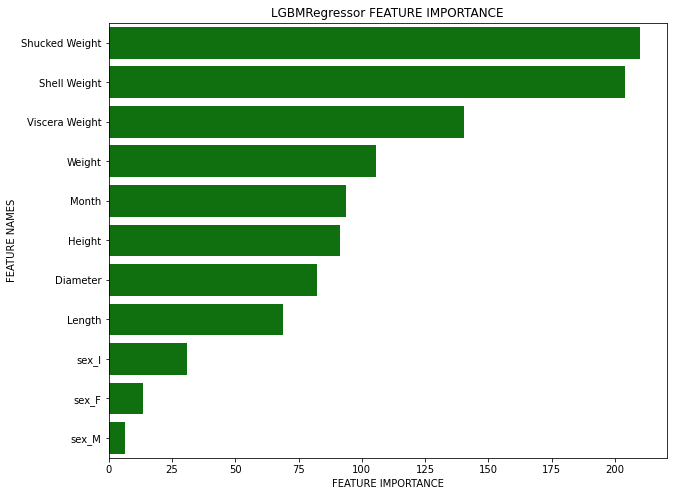

In [28]:
calc_feat = np.sum(df_feature.loc[np.argmax(df_test.mean(axis=1))]) / len(
    df_feature.loc[np.argmax(df_test.mean(axis=1))])
plt.figure(figsize=(10, 8))
z = dict(zip(df_crab_dum.columns.to_list(), calc_feat))
zipped = {k: z[k] for k in sorted(z, key=z.get, reverse=True)}
sns.barplot(x=list(zipped.values()), y=list(zipped.keys()), color='g')
plt.title('LGBMRegressor FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

Max Depth is aligned with hyperparameter from `GridSearchCV`

Highest Average Test Set Achieved = 0.851732
Max_Depth = 2


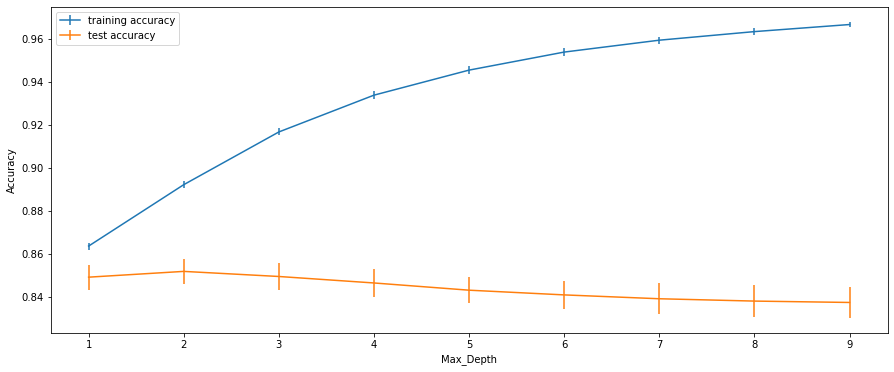

In [29]:
fig = plt.figure(figsize=(15, 6))
plt.errorbar(depth_settings,
             df_train.mean(axis=1),
             yerr=df_train.std(axis=1),
             label="training accuracy")
plt.errorbar(depth_settings,
             df_test.mean(axis=1),
             yerr=df_test.std(axis=1),
             label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Max_Depth")
plt.legend()
bestdepth = np.argmax(df_test.mean(axis=1)) + 1
print("Highest Average Test Set Achieved = %f" % np.amax(df_test.mean(axis=1)))
print("Max_Depth = %d" % bestdepth)

### CatBoostRegressor 

In [31]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_feature = pd.DataFrame()
maxdepth_settings = len(df_crab.columns) + 1
start_time = time.time()
for seedN in range(1, 20, 1):
    X_train, X_test, y_train, y_test = train_test_split(df_crab_dum,
                                                        df_crab['Age'],
                                                        test_size=0.25,
                                                        random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    features_importance = []
    depth_settings = range(1,
                           maxdepth_settings)  # try n_neighbors from 1 to 50

    for depth in depth_settings:
        forest = CatBoostRegressor(silent=True,
                                   max_depth=depth,
                                   learning_rate=0.01)
        forest.fit(X_train, y_train)
        training_accuracy.append(forest.score(X_train, y_train))
        test_accuracy.append(forest.score(X_test, y_test))
        features_importance.append(forest.feature_importances_)
    df_train[seedN] = training_accuracy
    df_test[seedN] = test_accuracy
    df_feature[seedN] = features_importance
end_time = time.time() - start_time
print(f'Total Run Time {end_time}')

Total Run Time 152.06004309654236


Feature importance is ligned based on expectations that would be the top predictors

Text(0, 0.5, 'FEATURE NAMES')

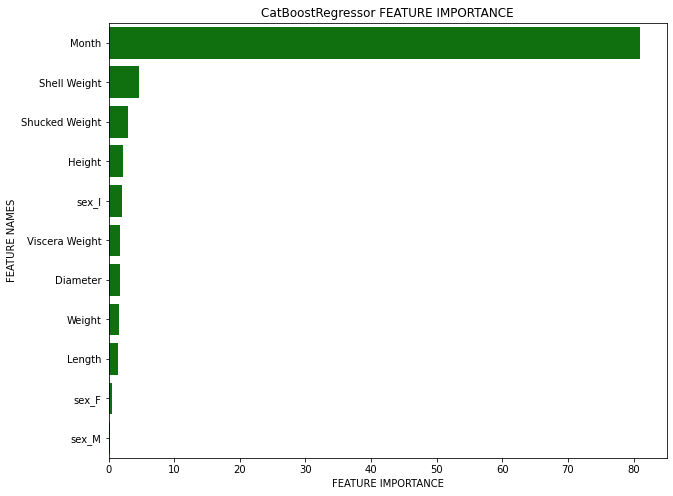

In [32]:
calc_feat = np.sum(df_feature.loc[np.argmax(df_test.mean(axis=1))]) / len(
    df_feature.loc[np.argmax(df_test.mean(axis=1))])

plt.figure(figsize=(10, 8))
z = dict(zip(df_crab_dum.columns.to_list(), calc_feat))
zipped = {k: z[k] for k in sorted(z, key=z.get, reverse=True)}
sns.barplot(x=list(zipped.values()), y=list(zipped.keys()), color='g')
plt.title('CatBoostRegressor FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

Max Depth adjusted from 6 to 7 and not aligned from `GridSearchCV` though might be with the dataset we have.

Highest Average Test Set Achieved = 0.857776
Max_Depth = 7


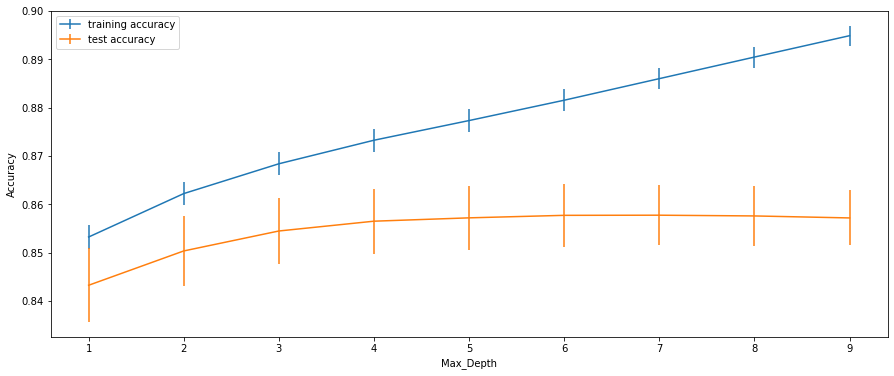

In [33]:
fig = plt.figure(figsize=(15, 6))
plt.errorbar(depth_settings,
             df_train.mean(axis=1),
             yerr=df_train.std(axis=1),
             label="training accuracy")
plt.errorbar(depth_settings,
             df_test.mean(axis=1),
             yerr=df_test.std(axis=1),
             label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Max_Depth")
plt.legend()
bestdepth = np.argmax(df_test.mean(axis=1)) + 1
print("Highest Average Test Set Achieved = %f" % np.amax(df_test.mean(axis=1)))
print("Max_Depth = %d" % bestdepth)

### XGBRegressor

In [34]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_feature = pd.DataFrame()
maxdepth_settings = len(df_crab.columns) + 1
start_time = time.time()

for seedN in range(1, 20, 1):
    X_train, X_test, y_train, y_test = train_test_split(df_crab_dum,
                                                        df_crab['Age'],
                                                        test_size=0.25,
                                                        random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    features_importance = []
    depth_settings = range(1,
                           maxdepth_settings)  # try n_neighbors from 1 to 50

    for depth in depth_settings:
        forest = xgb.XGBRegressor(verbosity=0, max_depth=depth)
        forest.fit(X_train, y_train)
        training_accuracy.append(forest.score(X_train, y_train))
        test_accuracy.append(forest.score(X_test, y_test))
        features_importance.append(forest.feature_importances_)
    df_train[seedN] = training_accuracy
    df_test[seedN] = test_accuracy
    df_feature[seedN] = features_importance
end_time = time.time() - start_time
print(f'Total Run Time {end_time}')

Total Run Time 27.866318702697754


Same feature importance as Catboost

Text(0, 0.5, 'FEATURE NAMES')

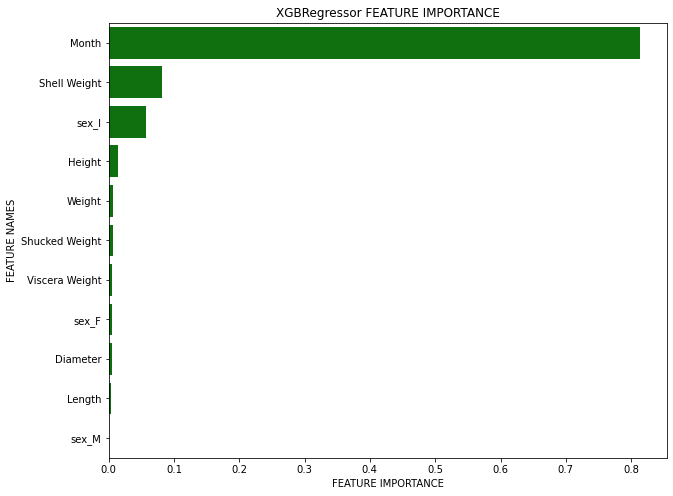

In [36]:
calc_feat = np.sum(df_feature.loc[np.argmax(df_test.mean(axis=1))]) / len(
    df_feature.loc[np.argmax(df_test.mean(axis=1))])

plt.figure(figsize=(10, 8))
z = dict(zip(df_crab_dum.columns.to_list(), calc_feat))
zipped = {k: z[k] for k in sorted(z, key=z.get, reverse=True)}
sns.barplot(x=list(zipped.values()), y=list(zipped.keys()), color='g')
plt.title('XGBRegressor FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

Max Depth is aligned with hyperparameter from `GridSearchCV`

Highest Average Test Set Achieved = 0.855361
Max_Depth = 2


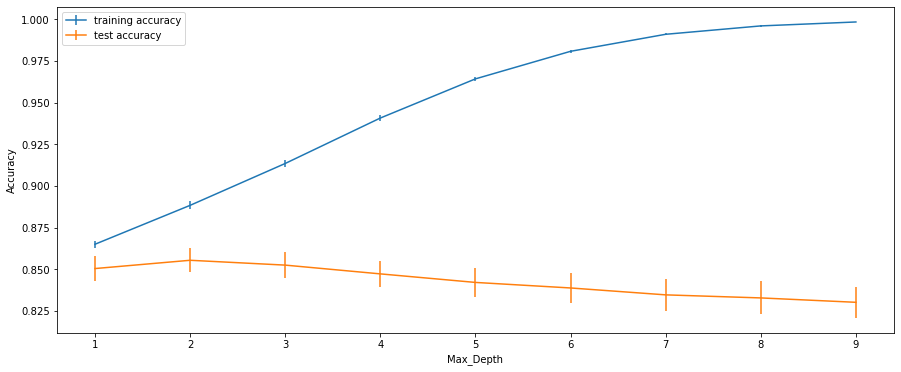

In [35]:
fig = plt.figure(figsize=(15, 6))
plt.errorbar(depth_settings,
             df_train.mean(axis=1),
             yerr=df_train.std(axis=1),
             label="training accuracy")
plt.errorbar(depth_settings,
             df_test.mean(axis=1),
             yerr=df_test.std(axis=1),
             label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Max_Depth")
plt.legend()
bestdepth = np.argmax(df_test.mean(axis=1)) + 1
print("Highest Average Test Set Achieved = %f" % np.amax(df_test.mean(axis=1)))
print("Max_Depth = %d" % bestdepth)

### Summary of the 3 executions:

In this test, the results are nearly identical to the tests with `GridSearchCV` though we need to take note we only executed `GridSearchCV` for a test once here in the last test we did an average of 20 sets. <br>

Given the accuracy with the minimal difference of .001 to .002 across the 3 models, I would use `LGB` for this scenario since the business case does not require super optimal accuracy and the run time would be faster overall based on recent tests. The reason why run the total run time in `GridSearchCV` for `LGB` is higher since there were more parameters being tested across but the fit means time being the fastest and the validation and test are quite fast across.

__`LGB`__<br>

Highest Average Test Set Achieved = 0.856220<br>
GridSearchCV Test = 0.855851<br>
Max_Depth = 4<br>
Total Run Time = 8.387618780136108<br>

__`Catboost`__<br>
Highest Average Test Set Achieved = 0.857776<br>
GridSearchCV Test = 0.855314<br>
Max_Depth = 7<br>
Total Run Time = 158.3528242111206<br>

__`XGB`__<br>
Highest Average Test Set Achieved = 0.855361<br>
GridSearchCV Test = 0.855280<br>
Max_Depth = 2<br>
Total Run Time = 22.163251876831055

In [83]:
display(df_isorted.head(3))

,Model,Scaler,Method / Estimators,Train Score,Validation Score,Test Score,Top Predictor,Fit Run Time,Val Run Time,Test Run Time,Total Run Time
17,LGB,None,"{'clf__learning_rate': 0.1, 'clf__max_bin': 700, 'clf__max_depth': 4, 'clf__n_estimators': 100, 'clf__verbose': -1}",0.894390,0.860462,0.855851,Shucked Weight,0.035048,0.002918,0.001611,69.020023
18,Catboost,None,"{'clf__depth': 6, 'clf__learning_rate': 0.01}",0.881268,0.862864,0.855314,Month,1.464523,0.003251,0.001601,11.362925
16,XGB,None,"{'clf__eta': 0.1, 'clf__max_depth': 4}",0.902840,0.864460,0.855280,Month,0.219571,0.002380,0.002773,16.074478


## Dropping of Multi-Colinear columns

In this test I've learned that if there is a multi-colinearity in the data set you can actually drop the columns that is linear to it and will only have minimal impact to ints accuracy.<br>

We will be using XGB as our selected model for presentation purpose since Height has the 4th highest weight in the prediction.

In this test we dropped `Length` and `Height` and we can see it still have near the same results with only a drop of around .0003 even though Height has the 4th highest weight in the prediction.

Highest Average Test Set Achieved = 0.855063
Max_Depth = 2


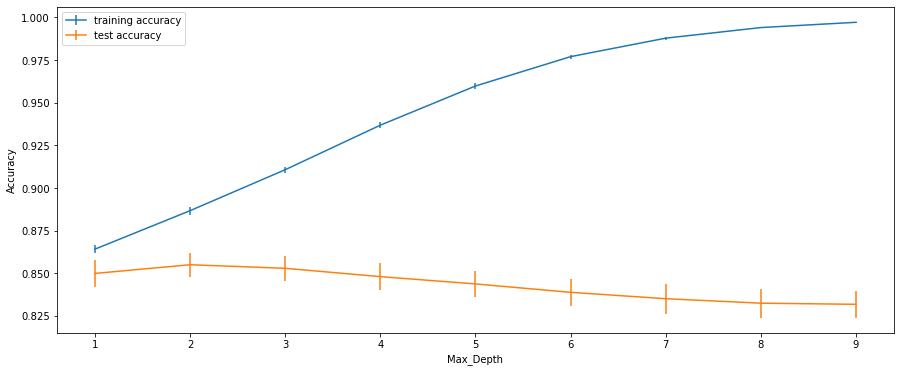

In [39]:
#Added
dummies = pd.get_dummies(df_crab_m.Sex, prefix='sex', drop_first=False)
df_crab_dum = pd.concat([df_crab_m, dummies], axis=1)
df_crab_dum.drop(['Sex', 'Age', 'Month', 'Length', 'Height'],
                 inplace=True,
                 axis=1)
df_crab_dum['Month'] = pd.cut(df_crab.Age,
                              list(range(0, 36, 6)),
                              labels=list(range(1, 6)))
df_crab_dum['Month'] = df_crab_dum['Month'].astype(int)

df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_feature = pd.DataFrame()
maxdepth_settings = len(df_crab.columns) + 1
for seedN in range(1, 20, 1):
    X_train, X_test, y_train, y_test = train_test_split(df_crab_dum,
                                                        df_crab['Age'],
                                                        test_size=0.25,
                                                        random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    features_importance = []
    depth_settings = range(1,
                           maxdepth_settings)  # try n_neighbors from 1 to 50

    for depth in depth_settings:
        forest = xgb.XGBRegressor(verbosity=0, max_depth=depth)
        forest.fit(X_train, y_train)
        training_accuracy.append(forest.score(X_train, y_train))
        test_accuracy.append(forest.score(X_test, y_test))
        features_importance.append(forest.feature_importances_)

    df_train[seedN] = training_accuracy
    df_test[seedN] = test_accuracy
    df_feature[seedN] = features_importance

fig = plt.figure(figsize=(15, 6))
plt.errorbar(depth_settings,
             df_train.mean(axis=1),
             yerr=df_train.std(axis=1),
             label="training accuracy")
plt.errorbar(depth_settings,
             df_test.mean(axis=1),
             yerr=df_test.std(axis=1),
             label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Max_Depth")
plt.legend()
bestdepth = np.argmax(df_test.mean(axis=1)) + 1
print("Highest Average Test Set Achieved = %f" % np.amax(df_test.mean(axis=1)))
print("Max_Depth = %d" % bestdepth)

In this test we dropped 'Length' and 'Diameter' and we can see it improved by .0004

Highest Average Test Set Achieved = 0.855866
Max_Depth = 2


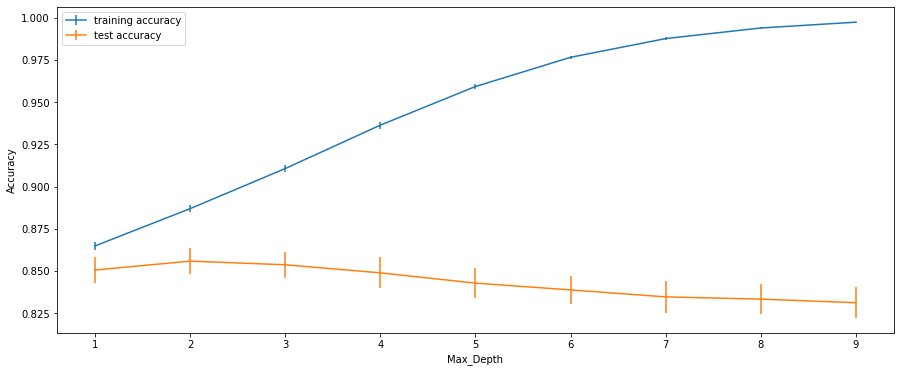

In [40]:
#Added
dummies = pd.get_dummies(df_crab_m.Sex, prefix='sex', drop_first=False)
df_crab_dum = pd.concat([df_crab_m, dummies], axis=1)
df_crab_dum.drop(['Sex', 'Age', 'Month', 'Length', 'Diameter'],
                 inplace=True,
                 axis=1)
df_crab_dum['Month'] = pd.cut(df_crab.Age,
                              list(range(0, 36, 6)),
                              labels=list(range(1, 6)))
df_crab_dum['Month'] = df_crab_dum['Month'].astype(int)

df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_feature = pd.DataFrame()
maxdepth_settings = len(df_crab.columns) + 1
for seedN in range(1, 20, 1):
    X_train, X_test, y_train, y_test = train_test_split(df_crab_dum,
                                                        df_crab['Age'],
                                                        test_size=0.25,
                                                        random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    features_importance = []
    depth_settings = range(1,
                           maxdepth_settings)  # try n_neighbors from 1 to 50

    for depth in depth_settings:
        forest = xgb.XGBRegressor(verbosity=0, max_depth=depth)
        forest.fit(X_train, y_train)
        training_accuracy.append(forest.score(X_train, y_train))
        test_accuracy.append(forest.score(X_test, y_test))
        features_importance.append(forest.feature_importances_)

    df_train[seedN] = training_accuracy
    df_test[seedN] = test_accuracy
    df_feature[seedN] = features_importance

fig = plt.figure(figsize=(15, 6))
plt.errorbar(depth_settings,
             df_train.mean(axis=1),
             yerr=df_train.std(axis=1),
             label="training accuracy")
plt.errorbar(depth_settings,
             df_test.mean(axis=1),
             yerr=df_test.std(axis=1),
             label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Max_Depth")
plt.legend()
bestdepth = np.argmax(df_test.mean(axis=1)) + 1
print("Highest Average Test Set Achieved = %f" % np.amax(df_test.mean(axis=1)))
print("Max_Depth = %d" % bestdepth)

## Recommended Final Data Set Post Presentation

Dropping these columns was a lingering idea before the presentation and after further analysis and feedback from one of my cohort mates on the data set we can't get the `Shucked` `Viscera` `Shell` Weights. This is due to the fact we need to kill the crab and part of the requirement is for the Crab to be delivered alive, dead crabs would be rejected and cannot be released.

In the data set below, we will be dropping these 3 columns and have this as a final result for our model.

In [84]:
#Added
dummies = pd.get_dummies(df_crab_m.Sex, prefix='sex', drop_first=False)
df_crab_dum = pd.concat([df_crab_m, dummies], axis=1)
df_crab_dum.drop([
    'Sex', 'Age', 'Month', 'Shucked Weight', 'Viscera Weight', 'Shell Weight'
],
                 inplace=True,
                 axis=1)
# df_crab_dum['Month'] = pd.cut(df_crab.Age,list(range(0, 34, 3)),
#                                   labels=list(range(1,12)))
df_crab_dum['Month'] = pd.cut(df_crab.Age,
                              list(range(0, 36, 6)),
                              labels=list(range(1, 6)))
df_crab_dum['Month'] = df_crab_dum['Month'].astype(int)
df_crab_dum.head(5)

,Length,Diameter,Height,Weight,sex_F,sex_I,sex_M,Month
0,1.4375,1.1750,0.4125,24.635715,1,0,0,2
1,0.8875,0.6500,0.2125,5.400580,0,0,1,1
2,1.0375,0.7750,0.2500,7.952035,0,1,0,1
3,1.1750,0.8875,0.2500,13.480187,1,0,0,2
4,0.8875,0.6625,0.2125,6.903103,0,1,0,1


In [85]:
X_trainval, X_test, y_trainval, y_test = train_test_split(df_crab_dum,
                                                          df_crab['Age'],
                                                          test_size=0.10,
                                                          random_state=619)
print('features trainval dimension =', X_trainval.shape)
print('target trainval dimension =', y_trainval.shape)

features trainval dimension = (3503, 8)
target trainval dimension = (3503,)


In [86]:
df_final = train_model(X_trainval, y_trainval, X_test, y_test)

/Users/bossrozz/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e+02, tolerance: 2.976e+00
  model = cd_fast.enet_coordinate_descent(
/Users/bossrozz/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.844e+02, tolerance: 2.931e+00
  model = cd_fast.enet_coordinate_descent(
/Users/bossrozz/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

In [87]:
df_fsorted = df_final.sort_values(by='Test Score', ascending=False)
df_fsorted.drop('Features', axis=1, inplace=True)
display(df_fsorted)

,Model,Scaler,Method / Estimators,Train Score,Validation Score,Test Score,Top Predictor,Fit Run Time,Val Run Time,Test Run Time,Total Run Time
17,LGB,None,"{'clf__learning_rate': 0.01, 'clf__max_bin': 255, 'clf__max_depth': 4, 'clf__n_estimators': 500, 'clf__verbose': -1}",0.863986,0.848000,0.844690,Diameter,0.095132,0.016759,0.002881,51.866017
14,GBM,None,"{'clf__learning_rate': 0.01, 'clf__max_depth': 4, 'clf__n_estimators': 500, 'clf__random_state': 0}",0.874224,0.852624,0.843399,Month,1.261034,0.006382,0.006288,142.437727
0,kNN,StandardScaler(),"{'clf__n_neighbors': 19, 'clf__weights': 'distance'}",1.000000,0.833183,0.842304,N/A,0.004029,0.010618,0.005722,4.680982
18,Catboost,None,"{'clf__depth': 4, 'clf__learning_rate': 0.01}",0.861148,0.853143,0.842302,Month,0.745561,0.003351,0.002698,7.685743
16,XGB,None,"{'clf__eta': 0.1, 'clf__max_depth': 2}",0.861182,0.852357,0.842073,Month,0.084658,0.002767,0.001787,10.890294
4,kNN,MinMaxScaler(),"{'clf__n_neighbors': 16, 'clf__weights': 'distance'}",1.000000,0.834421,0.837698,N/A,0.004480,0.008714,0.006783,3.916063
15,AdaBoost,None,"{'clf__learning_rate': 0.1, 'clf__n_estimators': 500}",0.841721,0.838412,0.834075,Month,0.247616,0.011798,0.004492,5.362645
12,DT,None,"{'clf__max_depth': 5, 'clf__random_state': 0}",0.861773,0.846565,0.824132,Month,0.003714,0.000716,0.000667,0.140961
8,kNN,Normalizer(),"{'clf__n_neighbors': 7, 'clf__weights': 'distance'}",1.000000,0.795246,0.816194,N/A,0.004212,0.006763,0.002576,2.667075
7,Ridge,MinMaxScaler(),"{'clf__alpha': 0.75, 'clf__max_iter': 1000000}",0.820346,0.817128,0.811500,Month,0.001668,0.000644,0.000742,0.149870


In [88]:
display(df_fsorted.head(3))

,Model,Scaler,Method / Estimators,Train Score,Validation Score,Test Score,Top Predictor,Fit Run Time,Val Run Time,Test Run Time,Total Run Time
17,LGB,None,"{'clf__learning_rate': 0.01, 'clf__max_bin': 255, 'clf__max_depth': 4, 'clf__n_estimators': 500, 'clf__verbose': -1}",0.863986,0.848000,0.844690,Diameter,0.095132,0.016759,0.002881,51.866017
14,GBM,None,"{'clf__learning_rate': 0.01, 'clf__max_depth': 4, 'clf__n_estimators': 500, 'clf__random_state': 0}",0.874224,0.852624,0.843399,Month,1.261034,0.006382,0.006288,142.437727
0,kNN,StandardScaler(),"{'clf__n_neighbors': 19, 'clf__weights': 'distance'}",1.000000,0.833183,0.842304,N/A,0.004029,0.010618,0.005722,4.680982


Here we have the final results and the models have now changed after dropping the 3 `Weights` and the results have dropped by .01% still a good % even though `XGB` and `Catboost` are in the 4th and 5th place which can still be considered if we can further tune it.

`LGB`, `GBM`, and `kNN` with `StandardScaler()` as its normalizing function.



## Final Run for LGB using the Tuned Parameters

In [89]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_feature = pd.DataFrame()
maxdepth_settings = len(df_crab.columns) + 1
start_time = time.time()

for seedN in range(1, 20, 1):

    X_train, X_test, y_train, y_test = train_test_split(df_crab_dum,
                                                        df_crab['Age'],
                                                        test_size=0.25,
                                                        random_state=seedN)
    training_accuracy = []
    test_accuracy = []
    features_importance = []
    depth_settings = range(1,
                           maxdepth_settings)  # try n_neighbors from 1 to 50

    for depth in depth_settings:
        forest = ltb.LGBMRegressor(verbose=-1,
                                   max_depth=depth,
                                   max_bin=700,
                                   learning_rate=0.1,
                                   n_estimators=500)
        forest.fit(X_train, y_train)
        training_accuracy.append(forest.score(X_train, y_train))
        test_accuracy.append(forest.score(X_test, y_test))
        features_importance.append(forest.feature_importances_)

    df_train[seedN] = training_accuracy
    df_test[seedN] = test_accuracy
    df_feature[seedN] = features_importance
end_time = time.time() - start_time
print(f'Total Run Time {end_time}')

Total Run Time 34.58474111557007


Interestingly again with the absence of `Shell Weight` it uses `Weight` in our manual script however in `GridSearchCV` it uses `Diameter` as its top predictor, this one behaves differently vs other trees since now almost every tree has used `Month` as its top predictor

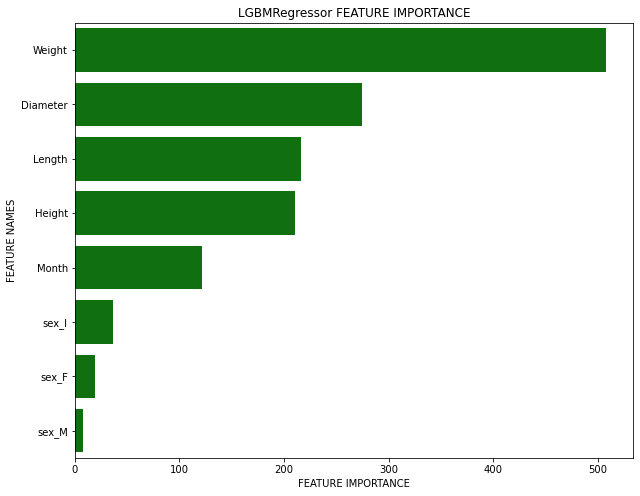

In [91]:
calc_feat = np.sum(df_feature.loc[np.argmax(df_test.mean(axis=1))]) / len(df_feature.loc[np.argmax(df_test.mean(axis=1))])
plt.figure(figsize=(10,8))
z = dict(zip(df_crab_dum.columns.to_list(), calc_feat))
zipped = {k: z[k] for k in sorted(z, key=z.get, reverse=True)}
sns.barplot(x=list(zipped.values()), y=list(zipped.keys()), color='g')
plt.title('LGBMRegressor FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES');


max_depth also adjusted from 4 to 2 however it has resulted having the highest average of 0.840 versus which is .004 lower than `GridSearchCV` might be because we averaged it now and have different data distribution.

Highest Average Test Set Achieved = 0.840355
Max_Depth = 2


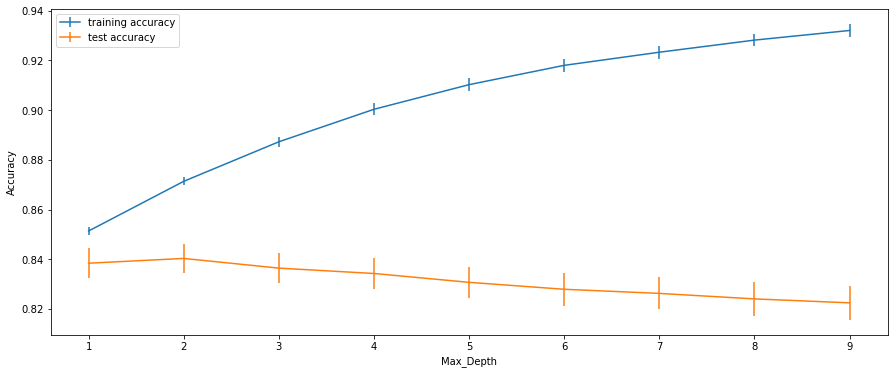

In [92]:
fig = plt.figure(figsize=(15, 6))
plt.errorbar(depth_settings,
             df_train.mean(axis=1),
             yerr=df_train.std(axis=1),
             label="training accuracy")
plt.errorbar(depth_settings,
             df_test.mean(axis=1),
             yerr=df_test.std(axis=1),
             label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Max_Depth")
plt.legend()
bestdepth = np.argmax(df_test.mean(axis=1)) + 1
print("Highest Average Test Set Achieved = %f" % np.amax(df_test.mean(axis=1)))
print("Max_Depth = %d" % bestdepth)

## Calculate Mean Absolute Error using FInal and Orignal Data Set 

This MAE calculation is done to show how far we are +- from our prediction given that do we really need to derive features further or not and justify it against the business case we have. We will be dropping the 3 weights to make the prediction realistic of the potential output of the data set.

In [50]:
#Added
dummies = pd.get_dummies(df_crab_m.Sex, prefix='sex', drop_first=False)
df_crab_dum = pd.concat([df_crab_m, dummies], axis=1)
df_crab_dum.drop([
    'Sex', 'Age', 'Month', 'Shucked Weight', 'Viscera Weight', 'Shell Weight'
],
                 inplace=True,
                 axis=1)
df_crab_dum['Month'] = pd.cut(df_crab.Age,
                              list(range(0, 36, 6)),
                              labels=list(range(1, 6)))
df_crab_dum['Month'] = df_crab_dum['Month'].astype(int)
df_crab_dum.head(5)
MAE = []

for seedN in range(1, 20, 1):
    X_train, X_test, y_train, y_test = train_test_split(df_crab_dum,
                                                        df_crab['Age'],
                                                        test_size=0.25,
                                                        random_state=seedN)

    forest = ltb.LGBMRegressor(verbose=-1,
                               max_depth=2,
                               max_bin=700,
                               learning_rate=0.1,
                               n_estimators=500)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    MAE.append(mean_absolute_error(y_test, y_pred))

print(f'Mean Absolute Error with Latest Data Set :  {np.mean(MAE)}')

df_crab_dum = pd.concat([df_crab, dummies], axis=1)
df_crab_dum.drop(
    ['Sex', 'Age', 'Shucked Weight', 'Viscera Weight', 'Shell Weight'],
    inplace=True,
    axis=1)

MAE = []
for seedN in range(1, 20, 1):
    X_train, X_test, y_train, y_test = train_test_split(df_crab_dum,
                                                        df_crab['Age'],
                                                        test_size=0.25,
                                                        random_state=seedN)

    forest = xgb.XGBRegressor(verbosity=0, max_depth=4)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    MAE.append(mean_absolute_error(y_test, y_pred))

print(f'Mean Absolute Error with Original Data Set : {np.mean(MAE)}')

Mean Absolute Error with Latest Data Set :  1.0064125656088108
Mean Absolute Error with Original Data Set : 1.843698662924635


Given the MAE above using the latest data set we are __+- 1-month__ with our predictions and with the original data set we are at __+- 1.8 months__. 

Given these, I think having a variance of just 1 month is good enough to say the age of a crab and be confident that we can farm them and 1.8 months is a bit large in this case. A farmer can easily decide if the crab is mature enough or if we can still grow them since the cutoff is around 6-8 months and there's a certain weight limit required but then again I will leave this to the domain experts since there are not much articles 

## Highlights

    1. Developing my own AutoML and using Pipeline, GridSearchCV and various models helped me immerse myself and code faster for Machine Learning. This saved me a lot of time during my testing of different features.
    
    2. Feature Engineering 
        a.) adding features help improve accuracy as long as the added features can be justified and have business sense. In this case, the added feature is possible and practical from my point of view. As mentioned I have also tried adding other calculated features but it did not help.
    
        b.) dropping multi-colinear features has minimal impact on accuracy, ideally, we discussed this in class, and kind of proven here in this study though I may need to test it in a dataset where these are the top predictors and how it impacts the results.

        c.) dropping features that are not possible to be collected, the data set presented shows the 3 different weights (Shucked, Viscera, and Shell) which can only be collected when a crab is dead does not apply to the business case.

    3. Predicting the age of animals or humans using their weight and height is not enough since there would be a cutoff at a certain point where it peaks and flattens out so we can't distinguish it anymore. We will need additional features to identify an animal or human to make our predictions more accurate. In the case of crabs per some articles it can be known base on the internal shell features like rings in the trees, unfortunately this is also not applicable due to the crab needs to be killed first before knowing this information which was one of the problems on the 3 weights in the dataset.
    
    4. Was able to learn more about the different variations of trees for example Catboost builds symmetric trees reason it runs slower since every depth uses the same splitting condition hence more computation but finer categorization. In the case of XGBoost, it grows asymmetrically but it grows depth by depth, the same as LightGBM it is asymmetric however it grows leaf-wise rather than the whole depth every time it builds on trees. There is a lot more cool stuff that I have read but kind of overwhelming to absorb them all and say which one is better and might be case to case.

## Conclusion

I have a relatively simple data set and am confident that I have provided enough insights on how we can utilize it, how we can further improve it, and what can be applicable given our business case. The feedback from one of my cohort mates pushed me to do the tests since I was not planning to do it but just wanted to complete the study and see the results I've added it and removing the features has minimal impact on the final results.

This project is a perfect exercise as it helped me practice my coding skills in a Machine Learning approach as I code very differently coming from a CS background with mostly Data Engineering experience. Learning some applicable techniques in Feature Engineering I believe will benefit me in the long run. The accuracy will still be based on the business need and I just wanted to improve it in ways the class can also learn from it a reason why I tried to do Feature Engineering on top of Hyperparameter tuning since I already did the significant test on the parameters with only little improvements in each iteration. I could have also stayed away from overfitting with a more granular Month value of around 3 but does not seem realistic and very synthetic for data to be collected in this assumption. 

Even with this simple and small data set it still took me relatively took me several hours to be convinced that this could be the peak of my results and needed validation from some of my cohort mates that this was already enough.

To close through extensive reading I can honestly say that I can potentially start my crab farm if I am interested in having a business in the future.

## References

- [1] Mud Crab Farming: Business Plan For Beginners (10-18-2022) https://www.roysfarm.com/mud-crab-farming/
- [2] Farming Mangrove Crab (Mud Crab) https://www.seafdec.org.ph/mangrove-crab-mud-crab/
- [3] How to Start a Mud Crab Farming Business (04-12-2021) https://businessdiary.com.ph/1249/how-to-start-a-mud-crab-farming-business/
- [4] Mudcrab (Alimango) Culture and Fattening https://www.pinoybisnes.com/aqua-business/mudcrab-culture-fattening-in-cages-in-mangroves/
- [5] Hpw to Start Crab Framing From Scratch https://www.agrifarming.in/how-to-start-crab-farming-from-scratch-a-detailed-guide-for-beginners
- [6] How old is that crab? https://www.adfg.alaska.gov/index.cfm?adfg=wildlifenews.view_article&articles_id=845
- [7] Getting Started with Feature Engineering (10-07-2020) https://www.analyticsvidhya.com/blog/2020/10/getting-started-with-feature-engineering/
- [8] 8 Feature Engineering Techniques for Machine Learning (09-22-20222) https://www.projectpro.io/article/8-feature-engineering-techniques-for-machine-learning/423
- [9] https://scikit-learn.org/stable/
- [10] https://catboost.ai
- [11] https://xgboost.readthedocs.io/en/stable/
- [12] https://lightgbm.readthedocs.io/en/v3.3.2/